In [1]:
import pymongo
import pandas as pd
from pymongo import MongoClient
from pandas import json_normalize
from sklearn.metrics import accuracy_score # importing "accuracy_score" from "sklearn.metrics"
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # Importing the Random forest algorithm
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
client = MongoClient('mongodb://localhost:27017/')


In [2]:
client.list_database_names()

['BDA', 'admin', 'atest', 'config', 'local']

In [3]:
db = client['BDA']

In [4]:
db.list_collection_names()

['Customers']

# Fetching the Data

In [5]:
collection = db.Customers

result = collection.find()

columns = set()

for document in result:
    columns.update(document.keys())

columns = list(columns)
print(columns)

['_id', 'Dependents', 'PaymentMethod', 'TotalCharges', 'Contract', 'PaperlessBilling', 'gender', 'tenure', 'SeniorCitizen', 'Services', 'MonthlyCharges', 'customerID', 'Partner']


In [6]:
nonecolumns = columns
x = {yy: {"$exists": True} for yy in nonecolumns}

result = collection.find(x, {"_id" : 0})
list_curr = list(result)
normalized_df = json_normalize(list_curr)
normalized_df = normalized_df.rename(columns=lambda x: x.replace('Services.', ''))
normalized_df['PaperlessBilling'] = normalized_df['PaperlessBilling'].astype(str)
normalized_df['PaperlessBilling'] = normalized_df['PaperlessBilling'].str.replace('[', '').str.replace(']', '')
normalized_df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,id7044,Male,0,Yes,No,15.208851,Month-to-month,'No',Credit card (automatic),45.682782,651.55,Yes,No,DSL,No internet service,Yes,No internet service,Yes,No,Yes
1,id7045,Male,0,No,Yes,29.779905,Month-to-month,'Yes',Credit card (automatic),40.301502,1359.7,No,Yes,DSL,No internet service,Yes,Yes,No internet service,Yes,Yes
2,id7046,Female,0,Yes,Yes,34.546357,Month-to-month,'Yes',Mailed check,59.778062,1752.55,Yes,No,DSL,Yes,No,Yes,No,No internet service,No internet service
3,id7047,Male,0,No,No,37.264434,Month-to-month,'Yes',Electronic check,58.392744,541.9,Yes,Yes,DSL,Yes,No,Yes,No internet service,No,Yes
4,id7049,Female,1,No,No,31.188870,Two year,'No',Bank transfer (automatic),87.322896,845.6,Yes,Yes,Fiber optic,No,Yes,Yes,No internet service,No internet service,No


In [7]:
normalized_df.shape

(23423, 20)

# Preparing The Data

Defining a fucntion to clean the Dataset

In [8]:
def sorttomodel(x):
    x = x.rename(columns=str.lower)
    for i in range(len(x)):
        y = x.at[i, 'multiplelines']
        if y == "No phone service":
            x.at[i, 'multiplelines'] = 0
        elif y == "No":
            x.at[i, 'multiplelines'] = 1
        else:
            x.at[i, 'multiplelines'] = 2
    x.rename(columns={'multiplelines': 'linenumber'}, inplace=True)
    x['linenumber'] = x['linenumber'].astype(int)

    x['supportlevel'] = x[['onlinesecurity', 'deviceprotection', 'techsupport','onlinebackup']].apply(lambda row: (row == 'Yes').sum(), axis=1)
    x['streaming'] = x[['streamingtv', 'streamingmovies']].apply(lambda row: (row == 'Yes').sum(), axis=1)
    for a in range(len(x)):
        y = x.at[a, 'contract']
        if y == "Month-to-month":
            x.at[a, 'contract'] = 0
        elif y == "One year":
            x.at[a, 'contract'] = 1
        else:
            x.at[a, 'contract'] = 2
    x.rename(columns={'contract': 'contract period (y)'}, inplace=True)
    x['contract period (y)'] = x['contract period (y)'].astype(int)
    x['InternetClassification'] = x['internetservice'].apply(lambda x: 1 if x == 'Fiber optic' else (2 if x == 'DSL' else 3))
    x['paymentmethodtype'] = ['Automatic' if 'automatic' in method.lower() else 'Manual' for method in x['paymentmethod']]
    dropped_column = x['customerid']
    x = x.drop(['streamingtv','streamingmovies','totalcharges'], axis=1)
    x = x.drop(['onlinesecurity', 'deviceprotection', 'techsupport','onlinebackup'],axis = 1)
    x = x.drop(['paymentmethod','internetservice'], axis=1)
    x.partner = (x.partner=='Yes').astype('int')
    x.dependents = (x.dependents=='Yes').astype('int')
    x.phoneservice = (x.phoneservice=='Yes').astype('int')
    x.paperlessbilling = (x.paperlessbilling=='Yes').astype('int')
    dropped_customerid = x['customerid']
    x = x.drop('customerid',axis=1)
    x = pd.get_dummies(x)
    x.gender_Female = x.gender_Female.astype(int)
    x.gender_Male = x.gender_Male.astype(int)
    x.paymentmethodtype_Automatic = x.paymentmethodtype_Automatic.astype(int)
    x.paymentmethodtype_Manual = x.paymentmethodtype_Manual.astype(int)
    x = x.rename(columns=str.lower)
    x = x.reindex(columns=sorted(x.columns))
    return x

In [9]:
churn = pd.read_csv("churn.CSV")
dropped_churn = churn['Churn']
dropped_customeridx = churn['customerID']
churn = churn.drop('Churn', axis=1)
churn = sorttomodel(churn)
churn = churn.rename(columns=str.lower)
churn['churn'] = dropped_churn
churn['customerid'] = dropped_customeridx
churn.loc[churn.churn == 'No', 'churn'] = 0
churn.loc[churn.churn == 'Yes', 'churn'] = 1
churn = churn.astype({"churn": 'int64'}) 
churn = churn.reindex(columns=sorted(churn.columns))



# Tranining the model using the fucntion

In [10]:
train, test = train_test_split(churn, test_size=1408, random_state=1, shuffle=True)
x_train = train.drop('churn', axis=1)
x_train = x_train.drop('customerid', axis=1) 

x_test = test.drop('churn', axis=1)
x_test = x_test.drop('customerid', axis=1)

y_test = test['churn']
customer_test = test['customerid'] 

clf = KNeighborsClassifier(n_neighbors=35)
y_train = train['churn']
clf.fit(x_train, y_train)
y_test_pred_Knn = clf.predict(x_test)
y_train_pred_Knn = clf.predict(x_train)


#psn_train = train['customerid'] 

# -------------------------K Nearest Neighbors ~0.81 accuraccy----------------------------------


In [11]:
test_acc = accuracy_score(y_test, y_test_pred_Knn)
print(f"The test accuracy of our model using k-nearest neighbors is {test_acc:.2f}")


The test accuracy of our model using k-nearest neighbors is 0.81


#### Defining a function to predict churn nesting the previous built function that is cleaning the data

In [15]:
def ChurnPrediction(x):
    orgds = x 
    x = sorttomodel(x)
    x = x.drop(columns=['churnpred'], errors='ignore')
    KnnDataSet = clf.predict(x)
    KnnDataSet_df = pd.DataFrame(KnnDataSet, index=x.index, columns=['ChurnPred'])
    orgds['ChurnPred'] = KnnDataSet_df['ChurnPred']
    return orgds


In [17]:
ChurnWithPred= ChurnPrediction(normalized_df)

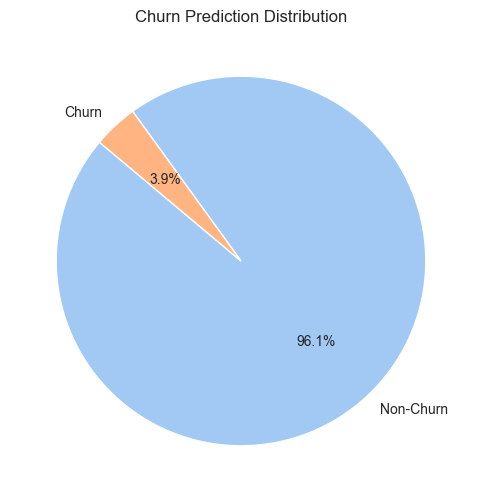

In [18]:
labels = ['Non-Churn', 'Churn']

counts = normalized_df['ChurnPred'].value_counts()

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))

plt.title('Churn Prediction Distribution')

plt.show()

In [19]:
# ChurnWithPred= ChurnPrediction(normalized_df)
ChurnWithPred.to_csv('ChurnWithPred.csv', index=False)
ChurnWithPred

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,...,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,ChurnPred
0,id7044,Male,0,Yes,No,15.208851,Month-to-month,'No',Credit card (automatic),45.682782,...,Yes,No,DSL,No internet service,Yes,No internet service,Yes,No,Yes,0
1,id7045,Male,0,No,Yes,29.779905,Month-to-month,'Yes',Credit card (automatic),40.301502,...,No,Yes,DSL,No internet service,Yes,Yes,No internet service,Yes,Yes,0
2,id7046,Female,0,Yes,Yes,34.546357,Month-to-month,'Yes',Mailed check,59.778062,...,Yes,No,DSL,Yes,No,Yes,No,No internet service,No internet service,0
3,id7047,Male,0,No,No,37.264434,Month-to-month,'Yes',Electronic check,58.392744,...,Yes,Yes,DSL,Yes,No,Yes,No internet service,No,Yes,0
4,id7049,Female,1,No,No,31.188870,Two year,'No',Bank transfer (automatic),87.322896,...,Yes,Yes,Fiber optic,No,Yes,Yes,No internet service,No internet service,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23418,id32038,Male,0,No,No,10.304650,Month-to-month,'Yes',Credit card (automatic),91.817322,...,Yes,Yes,Fiber optic,No internet service,Yes,Yes,Yes,Yes,No internet service,1
23419,id32039,Male,0,No,Yes,15.826004,Month-to-month,'No',Mailed check,71.692238,...,Yes,Yes,DSL,Yes,No,No,No,No,No internet service,0
23420,id32040,Male,0,No,Yes,33.852572,One year,'Yes',Mailed check,86.958880,...,Yes,Yes,Fiber optic,No internet service,No internet service,No,Yes,Yes,No,0
23421,id32041,Male,0,Yes,Yes,33.154407,Month-to-month,'Yes',Mailed check,76.120814,...,Yes,Yes,Fiber optic,No,Yes,No,No,No,No internet service,0


In [27]:
counts = normalized_df['ChurnPred'].value_counts()

total_count = counts.get(0, 0) + counts.get(1, 0)
count_of_c = counts.get(1, 0)

print("Out of", total_count, "predictions:")
print("Customer Churn Predicted is", count_of_c)
print(f"Predicted Customer Churn Rate is {(count_of_c / total_count):.3f}")

Out of 23423 predictions:
Customer Churn Predicted is 917
Predicted Customer Churn Rate is 0.039
